In [1]:
import os
import numpy as np
from scipy.spatial import distance
from scipy import stats
from scipy import optimize
import matplotlib.pyplot as plt

from wikisim import model
from wikisim import dsmplot

work_dir = '/Users/morton/Dropbox/work/bender/'
model_dir = os.path.join(work_dir, 'batch', 'models3')
fig_dir = os.path.join(work_dir, 'figs_wikisim3', 'schematic')
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

## Load sample models

In [2]:
model_names = ['hmax', 'subcat', 'wiki_w2v', 'wiki_use1', 'vem', 'sem', 'geo']
model_labels = ['hmx', 'sub', 'w2v', 'use', 'vem', 'sem', 'geo']
models = model.load_model_set(model_dir, model_names, model_labels=model_labels)

sem_rdm = models['face']['use']
vis_rdm = models['face']['hmx']

## Generate simulated data

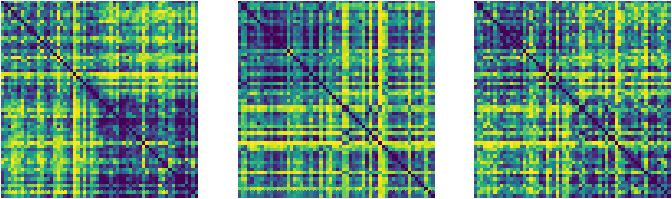

In [3]:
pat_rdm = vis_rdm + sem_rdm
pat_vec_raw = distance.squareform(pat_rdm)
pat_vec_raw = pat_vec_raw + np.random.randn(*pat_vec_raw.shape) * .07
pat_rdm = distance.squareform(pat_vec_raw)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
dsmplot.plot_dsm(vis_rdm, rank=True, ax=ax[0]);
dsmplot.plot_dsm(sem_rdm, rank=True, ax=ax[1]);
dsmplot.plot_dsm(pat_rdm, rank=True, ax=ax[2]);

## Calculate residuals

In [4]:
# create the control design matrix
control_rdms = [vis_rdm]
control_vecs = np.asarray([stats.rankdata(distance.squareform(rdm))
                           for rdm in control_rdms]).T
intercept = np.ones((control_vecs.shape[0],1))
control_mat = np.hstack((control_vecs, intercept))

# get model residuals
sem_vec = stats.rankdata(distance.squareform(sem_rdm))
beta = optimize.nnls(control_mat, sem_vec)[0]
sem_fit = control_mat.dot(beta)
sem_resid = sem_vec - sem_fit

# get pattern residuals
pat_vec = stats.rankdata(distance.squareform(pat_rdm))
beta = optimize.nnls(control_mat, pat_vec)[0]
pat_fit = control_mat.dot(beta)
pat_resid = pat_vec - pat_fit

## Plot results overview

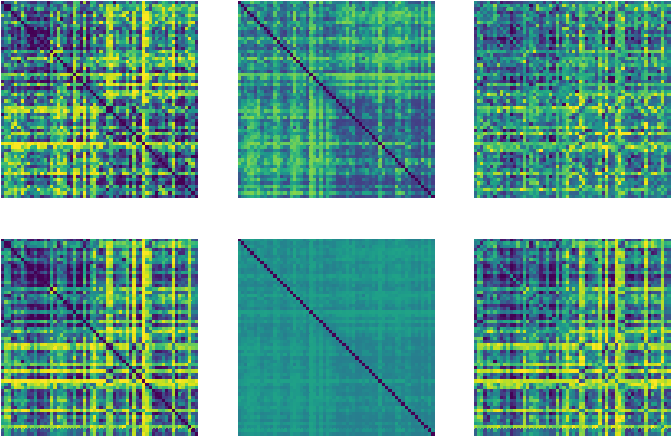

In [5]:
neural = {'rdm': pat_rdm, 'fit': distance.squareform(pat_fit),
          'res': distance.squareform(pat_resid)}
model = {'rdm': sem_rdm, 'fit': distance.squareform(sem_fit),
         'res': distance.squareform(sem_resid)}
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
for i, mset in enumerate([neural, model]):
    vmax = len(distance.squareform(mset['rdm']))
    dsmplot.plot_dsm(mset['rdm'], rank=True, ax=ax[i, 0])
    dsmplot.plot_dsm(mset['fit'], vlim=[0, vmax], ax=ax[i, 1])
    dsmplot.plot_dsm(mset['res'], ax=ax[i, 2])

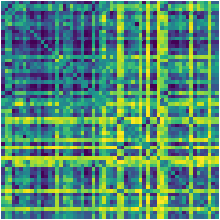

In [6]:
fig, ax = plt.subplots(figsize=(4, 4))
names = ['pat', 'sem']
kws = {'pad_inches': 0}
for i, mset in enumerate([neural, model]):
    vmax = len(distance.squareform(mset['rdm']))
    
    dsmplot.plot_dsm(mset['rdm'], rank=True, ax=ax)
    fig.savefig(os.path.join(fig_dir, f'demo_{names[i]}_rdm.png'), **kws)
    
    dsmplot.plot_dsm(mset['fit'], vlim=[0, vmax], ax=ax)
    fig.savefig(os.path.join(fig_dir, f'demo_{names[i]}_fit.png'), **kws)
    
    dsmplot.plot_dsm(mset['res'], ax=ax)
    fig.savefig(os.path.join(fig_dir, f'demo_{names[i]}_res.png'), **kws)